# Energy and gradients


## Total energy of the epithelium

### Notations

Each cell is devided in tetrahedra, one per edge:

![Tetrahedral element](../data/png/maille_elementaire.png)

Each tetrahedron is thus indexed by its cell ($c$), face ($\alpha$), source vertex ($i$) and target vertex ($j$). For each of those tetrahedron, we will mostly use 
* the edge **length** between the source $i$ and the target j $\ell_{ij}$
* the **height** between the face center $\alpha$ and the  cell center $c$ $h_{c\alpha}$,
* the **area** of the face $(\alpha ij)$,
* and the volume $V_\ell{c\alpha ij}$ of the whole tetrahedron. 

Thanks to the chosen topology, there is only one tetrahedron per edge (or half-edge in CGAL terms), and the above defined values are defined as $N_e$ vectors, where $N_e$ is the number of edges. In the code, they have the same index as `eptm.edge_df`.


### Sums

We define operators that perform grouped summation $\bigoplus ()$, for example "sum the length of all the edges of a face". Such operators are applied to: 
* the source vertex i: $\bigoplus_s$,
* the target vertex j: $\bigoplus_t$,
* the junction edge ij: $\bigoplus_e$,
* the face $\alpha$ : $\bigoplus_f$ 
* the cell c: $\bigoplus_c$.

The connectivity is implicit, and those sums are performed as `groupby` operations over all the tetrahedra (`edge_df` indexed `DataFrames`).

This way, all the face perimeters are given by the vector of length $N_f$: 

$$\mathbf{L}_f = \bigoplus_f (\ell_{ij})$$ .

Similarly:

* For the face areas: $\mathbf{A}_f = \bigoplus_f(A_{\alpha ij})$.
* For the **cell** outside areas: $\mathbf{A}_c = \bigoplus_c (A_{\alpha ij})$.
* For the cell volumes: $\mathbf{V}_c = \bigoplus_c (V_{c\alpha ij})$

Very often, one wants to sum over all the out-going edges of a given jonction vertex (force balance, anyone?), wich is equivalent to summing over the source vertex.

* out-edges forces: $\mathbf{F}_i = \bigoplus_s (\mathbf{F}_{c\alpha ij})$


The more classic big sigma notation ($\sum_f$ etc.) defines a sum over all the faces of the epithelium, and returns a scalar for a 1D input.

### 2D potential

According to the [Farhadifar et
al. paper](http://dx.doi.org/10.1016/j.cub.2007.11.049), in the case
of a regular hexagonal latice, energy is given by:

$$
E = \sum_f\frac{K}{2} (A - A_0)^2 + \sum_f\frac{\Gamma}{2} L^2 +
\sum_e\frac{\Lambda}{2}\ell
$$

_The factor 1/2 in the linear term is due to the half-edge geometry, this is more tricky in full 3D_.


### 3D Honda potential

This potential can be generalized to 3D by the adition of a volume term:

$$ E = \sum_c\frac{K_v}{2} (V_c - V_0)^2 + \sum_c\frac{K_a}{2} (A_\alpha - A_0)^2 + \sum_f\frac{\Gamma}{2}L_\alpha^2 + \sum_e\Lambda\ell_{ij} $$


### 2.5D

In the 2.5D case, the volume of a cell is given as $V_f = \bigoplus_f A_{\alpha ij}h_{i}$ where $h_i$ is the height of the source vertex of edge ${c, \alpha, i, j}$. The area elaticity is considered null.

# Forces


In a quasi-static approach, we want to compute the gradient of the energy at each vertex concuring to the optimisation. In a viscous dynamics approach, the same gradient will be use as the force term.

$$
\begin{aligned} 
   \mathbf{\nabla_i} E &= (\frac{\partial E}{\partial x_i},
                     \frac{\partial E}{\partial y_i},
                     \frac{\partial E}{\partial z_i}) \\
   \mathbf{\nabla_i} E &= K_c (V_c - V_0) \mathbf{\nabla_i} V_c + K_a (A_c - A_0) \mathbf{\nabla_i} A_c + \Gamma L_\alpha \mathbf{\nabla_i} L_\alpha  + \Lambda \mathbf{\nabla_i} \ell_{ij}
\end{aligned}
$$

The full gradient over all vertices can be expressed with the $\bigoplus$ operators as:



$$
\begin{aligned}
\{\nabla\ \mathbf{E}\} =  &\bigoplus_s \left(
                                             \mathbf{\nabla_i} E_t
                                           + \mathbf{\nabla_i} E_c 
                                           + \mathbf{\nabla_i} E_A
                                           + \mathbf{\nabla_i} E_V\right)\\
                          + &\bigoplus_t \left(
                                           - \mathbf{\nabla_j} E_c 
                                           + \mathbf{\nabla_j} E_A
                                           + \mathbf{\nabla_j} E_V\right)\\               
\end{aligned}
$$




### Expression of the gradients

* edge length: 
$$\mathbf{\nabla_i} \ell_{ij} = \frac{\mathbf{r}_{ij}}{\ell_{ij}}$$

* area:

$$\mathbf{\nabla_i} A_\alpha = 
            \frac{\mathbf{r}_{\alpha j} \times n_\tau}{A_\alpha}$$
   
$$\mathbf{\nabla_j} A_\alpha = 
           - \frac{\mathbf{r}_{\alpha i} \times n_\tau}{A_\alpha}$$
* volume:
    
$$\mathbf{\nabla_i} V_c = 
            \frac{\mathbf{r}_{ci} \times \mathbf{r}_{c\alpha}}{4}$$
   
$$\mathbf{\nabla_j} V_c = 
            - \frac{\mathbf{r}_{cj} \times \mathbf{r}_{c\alpha}}{4}$$
    


## Energy in a 'naked' monolayer

In [1]:
import sys
import pandas as pd
import numpy as np
from scipy import optimize

import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.solvers.isotropic_solver import bruteforce_isotropic_relax
from tyssue import config
import tyssue.dynamics.sheet_isotropic_model as iso

from tyssue.draw.plt_draw import quick_edge_draw, plot_forces, plot_scaled_energies
from tyssue.io import hdf5

from tyssue.draw.threejs_draw import view_3js


from tyssue.utils import single_cell 

In [2]:
from tyssue import Monolayer, Sheet
from tyssue import MonoLayerGeometry as geom
from tyssue.dynamics import BulkModel as model
from tyssue.core.generation import three_faces_sheet, extrude
specs = config.geometry.bulk_spec()


#_dsets, _ = three_faces_sheet()
#datasets = extrude(_dsets, method='translation')
#mono = Monolayer('mono', datasets, specs)
#mono = single_cell(mono, 0)


#datasets = hdf5.load_datasets('../data/hf5/small_ellipsoid.hf5',
#                              data_names=['vert', 'edge',
#                                          'face', 'cell'])
#mono = Monolayer('leg_disk', datasets, specs)

sheet = Sheet.planar_sheet_3d('flat', 7, 7, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')
mono = Monolayer('leg_disk', datasets, specs)

geom.center(mono)
geom.update_all(mono)

dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.05
dyn_specs['cell']['prefered_area'] = 6.
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] = 1.
dyn_specs['face']['contractility'] = 0.0
dyn_specs['edge']['line_tension'] = 0.0


mono.update_specs(dyn_specs, reset=True)


print(mono.edge_df.length.mean(),
      mono.cell_df.area.mean(),
      mono.cell_df.vol.mean())      

0.7779706447261607 5.984326474687257 1.0468749999999998


In [13]:
rdr, l = view_3js(mono)
rdr

In [18]:
def get_opposite_faces(mono):
    face_v = mono.edge_df.groupby('face').apply(lambda df: frozenset(df['srce']))
    face_v2 = pd.Series(data=face_v.index, index=face_v.values)
    mono.face_df['opposite'] = -1
    face_pairs = []
    face_v2.groupby(level=0).apply(lambda s: face_pairs.append(list(s.values))
                                   if len(s) == 2 else np.NaN).dropna()
    face_pairs = np.array(face_pairs)
    mono.face_df.loc[face_pairs[:, 0], 'opposite'] = face_pairs[:, 1]
    mono.face_df.loc[face_pairs[:, 1], 'opposite'] = face_pairs[:, 0]    
    
get_opposite_faces(mono)

edge_opp_face = mono.upcast_face(mono.face_df.opposite)
mono.border_es = mono.edge_df[(edge_opp_face < 0) &
                              (mono.edge_df['segment'] == 'sagittal')].index
mono.border_vs = mono.edge_df.loc[border_es, 'srce'].unique()


#mono.vert_df.loc[border_vs, 'is_active'] = 0

(30, 4)


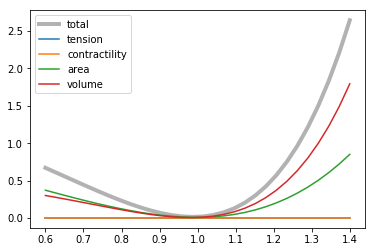

In [5]:
scales = np.linspace(0.6, 1.4, 30)
fig, ax = plot_scaled_energies(mono, geom, model,
                              scales, ax=None)

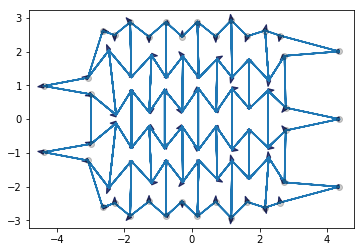

In [19]:
grad_i = model.compute_gradient(mono)

grad_i['norm'] = np.linalg.norm(grad_i[mono.coords], axis=1)
non_null = grad_i[grad_i.norm > 1e-1].index

arrow_scale = 10
fig, ax = plot_forces(mono, geom, model, list('xy'), scaling=arrow_scale)

ax.plot(mono.vert_df.loc[non_null, 'x'],
        mono.vert_df.loc[non_null, 'y'], 'ro')


ax.plot(mono.vert_df.loc[mono.border_vs, 'x'],
        mono.vert_df.loc[mono.border_vs, 'y'], 'ko', alpha=0.1);


In [6]:
bruteforce_isotropic_relax(mono, geom, model)

     fun: 0.3937147554493756
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 0.98820363802347133

In [68]:
mono.specs

{'cell': {'area': 0.0,
  'area_elasticity': 0.05,
  'is_alive': True,
  'num_faces': 6,
  'prefered_area': 6.0,
  'prefered_vol': 1.0,
  'vol': 0.0,
  'vol_elasticity': 1.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0},
 'edge': {'cell': 0,
  'dx': 0.0,
  'dy': 0.0,
  'dz': 0.0,
  'face': 0,
  'length': 0.0,
  'line_tension': 0.0,
  'nx': 0.0,
  'ny': 0.0,
  'nz': 0.0,
  'srce': 0,
  'sub_area': 0.0,
  'sub_vol': 0.0,
  'trgt': 0},
 'face': {'area': 0.0,
  'contractility': 0.0,
  'is_alive': True,
  'num_sides': 6,
  'perimeter': 0.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0},
 'settings': {'nrj_norm_factor': 1.0},
 'vert': {'is_active': True, 'x': 0.0, 'y': 0.0, 'z': 0.0}}

In [ ]:
from tyssue import BulkModel


class BulkModelwithFreeBorders(BulkModel):
    
    @classmethod
    def compute_energy(cls, eptm, full_output=False):
        
        E_bulk = BulkModel.compute_energy(full_output=False)
        E_brdr = cls.border_energy(eptm)
    
    @staticmethod
    def border_energy(eptm):
        
        E_brdr = eptm.edge_df.loc[eptm.border_es].eval(
            '0.5 * border_elasticity * (length - prefered_length)**2')
        return E_brdr.sum()

    @classmethod
    def compute_gradient(cls, eptm, components=False):
        
        pass
    

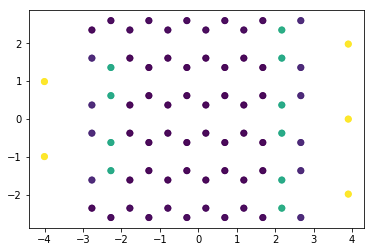

In [11]:
approx_grad = Solver.approx_grad(mono, geom, model).reshape((-1, 3))
grad_err = grad_i[mono.coords] - approx_grad

fig, ax = plt.subplots()

ax.scatter(mono.vert_df.x,
           mono.vert_df.y,
           c=np.linalg.norm(grad_err, axis=1),
           alpha=0.8)


(-3, 3)

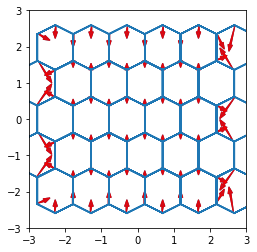

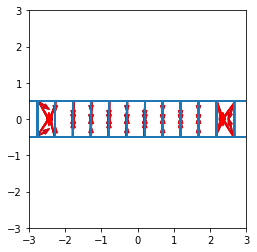

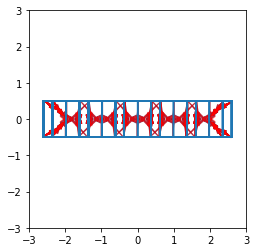

In [14]:
arrow_scale = 1.0


mono.cell_df.prefered_vol = 0.12 #0.06

fig, ax = plot_forces(mono, geom, model, list('xy'),
                      scaling=arrow_scale, ax=None)

fig, ax = plot_forces(mono, geom, model, list('xy'),
                      scaling=arrow_scale,
                      ax=ax,
                      approx_grad=Solver.approx_grad,
                      **{'grad':{'color': 'r'}})
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

fig, ax = plot_forces(mono, geom, model, list('xz'),
                      scaling=arrow_scale, ax=None)

fig, ax = plot_forces(mono, geom, model,
                      list('xz'), scaling=arrow_scale,
                      ax=ax,
                      approx_grad=Solver.approx_grad,
                      **{'grad':{'color': 'r'}})
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

fig, ax = plot_forces(mono, geom, model, list('yz'),
                      scaling=arrow_scale, ax=None)

fig, ax = plot_forces(mono, geom, model,
                      list('yz'), scaling=arrow_scale,
                      ax=ax,
                      approx_grad=Solver.approx_grad,
                      **{'grad':{'color': 'r'}})
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

In [15]:
mono.cell_df.prefered_vol = 0.6

In [16]:
res = Solver.find_energy_min(mono, geom, model)
print('Succesful first min: {}'.format(res['success']))
print(res['message'])

res = Solver.find_energy_min(mono, geom, model)
print('Successful secon min: {}'.format(res['success']))

Succesful first min: True
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Successful secon min: True


In [58]:
def lumen_area(mono):
    return mono.face_df.loc[mono.basal_faces, 'area'].sum()

lumen_area(mono)

178.2845746144171

In [17]:
#geom.scale(mono, 100, mono.coords)
rdr, l = view_3js(mono)
rdr

## Energy landscape in 2.5D

In [20]:
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model



In [21]:
# Load the data
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

# Set geometry
sheet = Sheet('rod', dsets,
              config.geometry.rod_sheet())

geom.reset_scafold(sheet)
geom.update_all(sheet)


# Tweak model parameters
dyn_specs = config.dynamics.quasistatic_sheet_spec()
dyn_specs['vert']['basal_shift'] = 0.
dyn_specs['face']['prefered_vol'] = 0.6
dyn_specs['face']['contractility'] = 0.02
dyn_specs['edge']['line_tension'] = 0.12

sheet.update_specs(dyn_specs, reset=True)
geom.update_all(sheet)


report = '\n'.join(
    ('mean height: {:.3f}'.format(
          sheet.face_df.height.mean()),
     'mean area: {:.3f}'.format(
          sheet.face_df.area.mean()),
     'mean volume: {:.3f}'.format(
          sheet.face_df.vol.mean()),
      ))
print(report)


Reseting datasets values with new specs


mean height: 1.030
mean area: 0.384
mean volume: 0.393


In [22]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 10.382004376297969


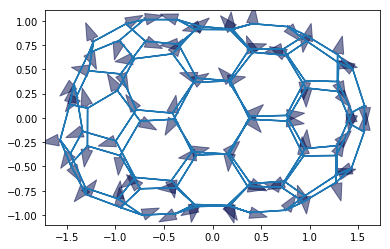

In [23]:
arrow_scale = 1

fig, ax = plot_forces(sheet, geom, model, list('zx'),
                      scaling=arrow_scale, ax=None)

In [24]:
model.compute_energy(sheet) / sheet.face_df.is_alive.sum() # should be around 0.46

0.21629175783954102

(30, 3)


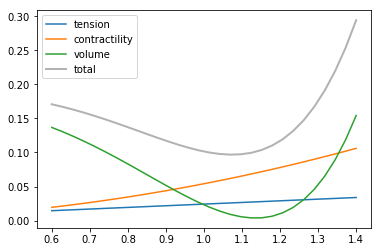

In [25]:
scales = np.linspace(0.6, 1.4, 30)
fig, ax = plot_scaled_energies(sheet, geom, model,
                              scales, ax=None)

In [26]:
res = Solver.find_energy_min(sheet, geom, model)
print('Succesful first min: {}'.format(res['success']))


Succesful first min: True


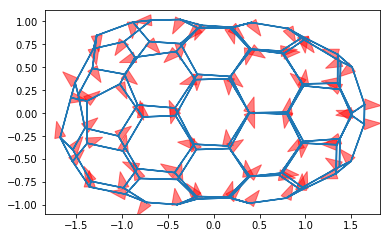

In [27]:
fig, ax = plot_forces(sheet, geom, model,
                      ['z', 'x'], scaling=0.1,
                      ax=None,
                      approx_grad=Solver.approx_grad,
                      **{'grad':{'color': 'r'}})
